<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/hypoAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis learning: toy data example

This notebook demonstrates how to apply the hypothesis learning to toy data. The [hypothesis learning](https://arxiv.org/abs/2112.06649) is based on the idea that in active learning, the correct model of the system’s behavior leads to a faster decrease in the overall Bayesian uncertainty about the system under study. In the hypothesis learning setup, probabilistic models of the possible system’s behaviors (hypotheses) are wrapped into structured GPs, and a basic reinforcement learning policy is used to select a correct model from several competing hypotheses.

*Prepared by Maxim Ziatdinov (March 2022)*

Installations:

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

In [ ]:
#@title Imports
from typing import Union, Dict, Type

import gpax

import jax.numpy as jnp
import jax.random as jra
import numpy as onp
import numpyro
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

In [ ]:
#@title Plotting and data utilities { form-width: "20%" }

def get_training_data(X, Y, num_seed_points=2, rng_seed=42, **kwargs):
    onp.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = kwargs.get("list_of_indices")
    if idx is not None:
        idx = onp.array(idx)
    else:
        idx = onp.random.randint(0, len(X), num_seed_points)
    idx = onp.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test
    

def plot_results(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_measured, y_measured, marker='x', s=100, c='k', label="Measured points", zorder=1)
    ax1.plot(X, y_pred, c='red', label='Model reconstruction', zorder=0)
    ax1.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                     color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    ax1.set_xlabel("$x$", fontsize=18)
    ax1.set_ylabel("$y$", fontsize=18)
    ax2.plot(X_unmeasured, obj, c='k')
    ax2.vlines(X_unmeasured[obj.argmax()], obj.min(), obj.max(), linestyles='dashed', label= "Next point")
    ax2.set_xlabel("$x$", fontsize=18)
    ax2.set_ylabel("Acquisition function", fontsize=18)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, onp.around(rewards, 3).tolist()), fontsize=24)
    fig.savefig("./{}.png".format(step))
    plt.show() 
    

def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()
    

def plot_final_result(X, y, X_test, y_pred, y_sampled, seed_points):
    plt.figure(dpi=100)
    plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = jnp.arange(2, len(X[seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    plt.plot(X_test, truefunc, c='k', label="Ground truth", zorder=0)
    plt.fill_between(X_test, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                            color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("$y$", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

First, let's generate some data. As a practical example chosen here, we are interested in the active learning of phase
diagram that has a transition between different phases. The phase transition manifests in discontinuity of a measurable system’s property, such as heat capacity. However, we usually do not know where a phase transition occurs precisely, nor are we aware of the exact behavior of the property of interest in different phases. We note that using a standard Gaussian process-based active learning is not an optimal choice in such a case as simple GP struggles around the discontinuity point.

Text(0, 0.5, '$y$')

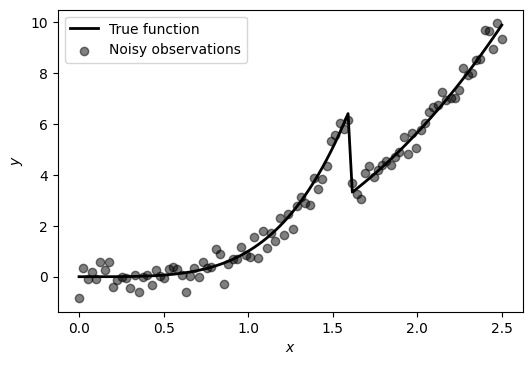

In [ ]:
def function_(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


X = jnp.linspace(0.0, 2.5, 100)
params = {"t": 1.6, "beta1": 4, "beta2": 2.5}

truefunc = function_(X, params)
Y = truefunc + 0.33 * jra.normal(jra.PRNGKey(0), shape=truefunc.shape)

_, ax = plt.subplots(dpi=100)            
ax.scatter(X, Y, alpha=0.5, c='k', label="Noisy observations")
ax.plot(X, truefunc, lw=2, c='k', label="True function")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

Define possible models of system's behavior as dereministic functions:

In [ ]:
def piecewise1(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta"], lambda x: params["c"]*x])
    
def piecewise2(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x])
    
def piecewise3(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])

Put priors over parameters of each model to make them probabilistic:

In [ ]:
def piecewise1_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta = numpyro.sample("beta", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta": beta, "c": c}

def piecewise2_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    b = numpyro.sample("b", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

def piecewise3_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(3, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}

Let's also specify custom priors over GP kernel:

In [ ]:
 def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
     length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
     scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
     return {"k_length": length, "k_scale": scale}

Helper functions for running the hypothesis learning:

In [ ]:
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model, model_prior, X_train, y_train, X_new=None, num_restarts=1, **kwargs):
    """Compute model posterior and use it to derive acqusition function"""
    acq_fn = gpax.acquisition.UE
    verbose = kwargs.get("print_summary", True)
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior. In the paper, we used
        # num_samples = num_warmup = 5000 but that takes some time
        gp_model = gpax.ExactGP(
            1, 'Matern', kernel_prior=gp_kernel_prior,
            mean_fn=model, mean_fn_prior=model_prior)
        gp_model.fit(
            rng_key, X_train, y_train, num_warmup=2000,
            num_samples=2000, num_chains=1, print_summary=verbose)
        rhats = [sgr(v).item() for v in gp_model.get_samples(1).values()]
        if max(rhats) < 1.1:
            break 
    # Compute acquisition function
    obj = 0
    if X_new is not None:
        obj = acq_fn(rng_key_predict, gp_model, X_new)
    return obj, gp_model

def update_datapoints(next_point_idx, train, test):
    """Update "measured" dummy data points"""
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, y_test[next_point_idx])
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point_idx)
    indices_test = jnp.delete(indices_test, next_point_idx)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

Generate seed points:

In [ ]:
(X_train, y_train, X_test, y_test,
     indices_train, indices_test) = get_training_data(X, Y, list_of_indices=[0, 33, 66, 99])
num_seed_points = len(X_train)

The main part (Algorithm 1 in the paper):

Warmup step 1/3


sample: 100%|██████████| 4000/4000 [00:24<00:00, 162.74it/s, 1023 steps of size 3.26e-03. acc. prob=0.76]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.62      0.87      2.51      1.40      4.19    513.33      1.00
         c      3.37      0.52      3.40      2.51      4.18    518.68      1.00
  k_length      0.46      0.29      0.45      0.00      0.88    713.82      1.00
   k_scale      1.18      1.22      0.81      0.07      2.55    854.43      1.00
     noise      1.24      1.29      0.87      0.06      2.63    658.38      1.00
         t      1.52      0.42      1.70      0.83      2.00    361.99      1.00



sample: 100%|██████████| 4000/4000 [00:19<00:00, 206.09it/s, 1023 steps of size 2.18e-03. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.48      0.88      2.38      1.16      3.95    361.32      1.00
         c      3.39      0.54      3.43      2.52      4.25    506.65      1.00
  k_length      0.51      0.29      0.53      0.01      0.90    466.31      1.00
   k_scale      1.36      1.33      0.94      0.06      2.85    604.46      1.00
     noise      1.31      1.36      0.91      0.04      2.77    472.10      1.00
         t      1.50      0.44      1.69      0.76      2.00    284.39      1.00



sample: 100%|██████████| 4000/4000 [00:06<00:00, 600.32it/s, 15 steps of size 4.39e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.88      1.00      2.85      1.17      4.44   1387.64      1.00
     beta2      2.42      0.16      2.43      2.19      2.67   1234.74      1.00
  k_length      0.51      0.29      0.50      0.10      1.00   1653.89      1.00
   k_scale      0.86      0.80      0.62      0.04      1.82   1488.36      1.00
     noise      0.85      0.84      0.58      0.04      1.74   1697.79      1.00
         t      1.16      0.39      1.16      0.50      1.67   1402.66      1.00

Warmup step 2/3


sample: 100%|██████████| 4000/4000 [00:12<00:00, 330.59it/s, 255 steps of size 1.65e-02. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.93      0.93      2.91      1.40      4.46    978.65      1.00
         c      3.27      0.49      3.28      2.38      4.00   1452.27      1.00
  k_length      0.44      0.30      0.42      0.00      0.89   1221.52      1.00
   k_scale      1.20      1.25      0.84      0.07      2.55   1299.67      1.00
     noise      1.95      1.51      1.59      0.10      3.65   1330.92      1.00
         t      1.23      0.39      1.23      0.54      1.82   1322.04      1.00



sample: 100%|██████████| 4000/4000 [00:09<00:00, 439.36it/s, 31 steps of size 1.11e-01. acc. prob=0.83] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.77      0.91      2.74      1.33      4.31   1068.48      1.00
         c      3.29      0.56      3.30      2.49      4.29    698.60      1.00
  k_length      0.47      0.30      0.46      0.00      0.90   1054.74      1.00
   k_scale      1.33      1.47      0.90      0.03      2.75    469.21      1.00
     noise      2.05      1.55      1.69      0.17      3.64   1134.67      1.00
         t      1.27      0.44      1.27      0.65      1.99   1135.40      1.00



sample: 100%|██████████| 4000/4000 [00:28<00:00, 141.19it/s, 1023 steps of size 2.37e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.70      0.46      3.78      2.90      4.37      7.57      1.37
     beta2      2.47      0.12      2.47      2.26      2.65      4.65      1.44
  k_length      0.46      0.30      0.42      0.06      0.94      9.73      1.03
   k_scale      0.68      0.44      0.57      0.09      1.21     30.67      1.03
     noise      1.18      1.00      1.02      0.04      2.55      4.31      1.74
         t      1.56      0.13      1.60      1.28      1.67     17.52      1.18

Warmup step 3/3


sample: 100%|██████████| 4000/4000 [00:10<00:00, 383.73it/s, 127 steps of size 3.19e-02. acc. prob=0.80] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.97      0.95      2.96      1.43      4.63   1127.77      1.00
         c      3.20      0.51      3.19      2.35      4.05    866.11      1.00
  k_length      0.45      0.30      0.41      0.00      0.88   1150.91      1.00
   k_scale      1.25      1.18      0.89      0.07      2.63   1230.32      1.00
     noise      1.77      1.25      1.50      0.20      3.31    966.88      1.00
         t      1.25      0.40      1.24      0.68      1.98    861.01      1.00



sample: 100%|██████████| 4000/4000 [00:22<00:00, 175.90it/s, 1023 steps of size 3.29e-03. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.74      0.86      2.70      1.21      4.02    941.87      1.00
         c      3.28      0.53      3.27      2.44      4.18    688.67      1.00
  k_length      0.45      0.30      0.43      0.00      0.88   1024.45      1.00
   k_scale      1.34      1.35      0.95      0.06      2.76   1024.58      1.00
     noise      1.79      1.30      1.45      0.20      3.25   1382.90      1.00
         t      1.32      0.45      1.34      0.69      2.00    848.68      1.00



sample: 100%|██████████| 4000/4000 [00:29<00:00, 135.07it/s, 1023 steps of size 1.10e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.70      0.20      3.71      3.35      3.98     13.36      1.20
     beta2      2.35      0.12      2.37      2.16      2.50      2.66      3.02
  k_length      0.69      0.16      0.74      0.41      0.90      5.78      1.23
   k_scale      0.65      0.36      0.58      0.14      1.06      6.18      1.30
     noise      0.36      0.11      0.36      0.20      0.48      4.07      1.37
         t      1.59      0.02      1.59      1.57      1.61    112.90      1.00

Exploration step 4/15
Using model 1


sample: 100%|██████████| 4000/4000 [00:14<00:00, 274.45it/s, 255 steps of size 1.23e-02. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.96      0.94      2.97      1.56      4.63    885.79      1.00
         c      3.27      0.47      3.25      2.51      4.08    988.09      1.00
  k_length      0.43      0.31      0.38      0.00      0.88    883.19      1.00
   k_scale      1.19      1.21      0.83      0.07      2.52   1000.59      1.00
     noise      1.85      1.14      1.58      0.28      3.44    997.16      1.00
         t      1.22      0.38      1.22      0.52      1.77    979.26      1.00



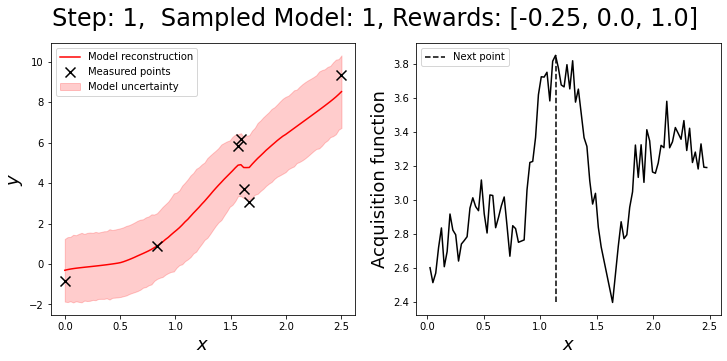

Exploration step 5/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:39<00:00, 100.29it/s, 1023 steps of size 7.85e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.80      0.26      3.81      3.39      4.25     44.71      1.08
     beta2      2.44      0.11      2.43      2.26      2.62     24.53      1.09
  k_length      0.48      0.29      0.48      0.03      0.89     74.24      1.00
   k_scale      0.67      0.69      0.49      0.03      1.29     39.01      1.01
     noise      0.54      0.43      0.41      0.05      1.10     27.33      1.01
         t      1.60      0.01      1.60      1.59      1.62     23.33      1.06



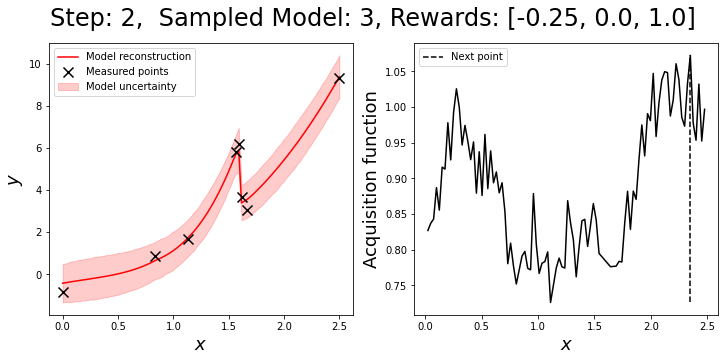

Exploration step 6/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:41<00:00, 95.48it/s, 1023 steps of size 1.29e-03. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.64      0.83      2.65      1.26      3.89    466.29      1.00
         c      3.38      0.45      3.37      2.66      4.11    142.61      1.02
  k_length      0.47      0.31      0.48      0.00      0.90    191.07      1.00
   k_scale      1.23      1.14      0.90      0.09      2.59    394.35      1.00
     noise      1.67      0.97      1.43      0.26      3.04    242.22      1.00
         t      1.32      0.42      1.34      0.69      2.00    168.45      1.01



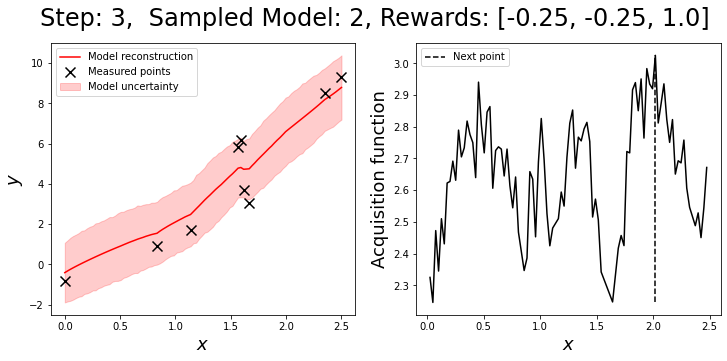

Exploration step 7/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:57<00:00, 69.44it/s, 1023 steps of size 1.34e-03. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.84      0.20      3.86      3.50      4.15    229.07      1.00
     beta2      2.45      0.10      2.46      2.29      2.61    163.36      1.01
  k_length      0.57      0.28      0.61      0.12      0.98     96.41      1.00
   k_scale      0.58      0.57      0.40      0.03      1.21    198.00      1.00
     noise      0.36      0.31      0.28      0.05      0.69    116.43      1.00
         t      1.60      0.01      1.60      1.59      1.62    104.91      1.00



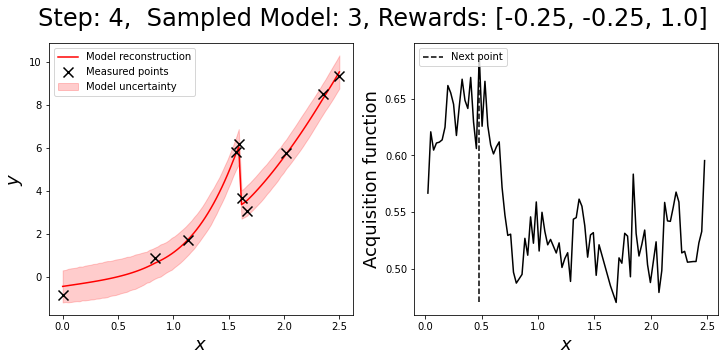

Exploration step 8/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:06<00:00, 60.27it/s, 1023 steps of size 1.50e-03. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.85      0.19      3.86      3.57      4.18    289.01      1.00
     beta2      2.45      0.09      2.45      2.30      2.61    214.06      1.01
  k_length      0.59      0.28      0.64      0.15      1.00    136.27      1.00
   k_scale      0.50      0.50      0.36      0.05      1.09    245.19      1.00
     noise      0.31      0.23      0.25      0.05      0.56    112.05      1.00
         t      1.60      0.01      1.60      1.59      1.62    124.97      1.01



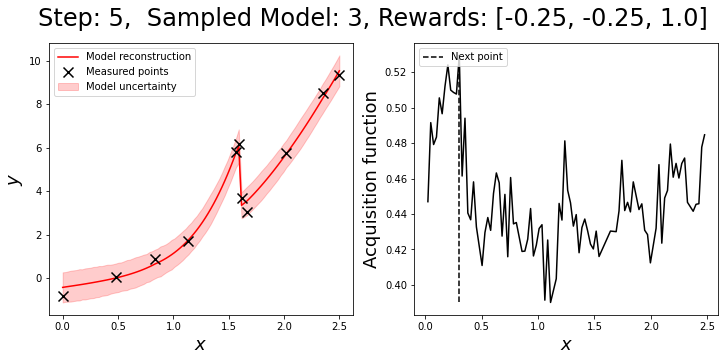

Exploration step 9/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:48<00:00, 81.65it/s, 1023 steps of size 7.68e-05. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.33      0.34      4.28      3.82      4.79      6.40      1.49
         c      2.82      0.38      2.90      2.19      3.26      2.98      2.53
  k_length      0.62      0.17      0.63      0.37      0.86      6.87      1.02
   k_scale      2.43      0.46      2.41      1.69      3.15     14.65      1.00
     noise      0.32      0.19      0.25      0.11      0.61      3.01      1.83
         t      1.61      0.01      1.60      1.59      1.62     82.14      1.04



sample: 100%|██████████| 4000/4000 [00:51<00:00, 77.93it/s, 1023 steps of size 6.28e-05. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.61      0.30      4.64      4.09      5.12      7.04      1.33
         c      3.33      0.15      3.28      3.15      3.59      3.79      1.32
  k_length      0.58      0.13      0.60      0.35      0.76      6.16      1.40
   k_scale      1.75      0.29      1.83      1.18      2.11      7.57      1.15
     noise      0.60      0.13      0.60      0.41      0.83      3.00      1.99
         t      1.61      0.01      1.61      1.59      1.63     66.28      1.05



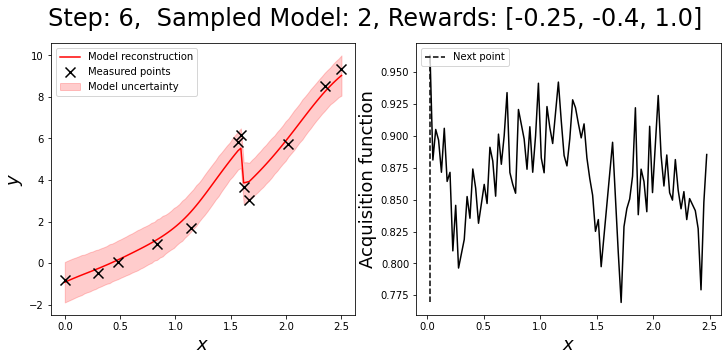

Exploration step 10/15
Using model 1


sample: 100%|██████████| 4000/4000 [01:05<00:00, 61.39it/s, 1023 steps of size 1.18e-03. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.20      0.89      3.24      1.75      4.59     69.80      1.03
         c      3.26      0.35      3.27      2.69      3.81    150.13      1.03
  k_length      0.47      0.30      0.46      0.00      0.90     89.75      1.02
   k_scale      0.93      0.92      0.66      0.07      1.90    174.27      1.00
     noise      1.13      0.62      1.02      0.22      2.02    147.46      1.00
         t      1.33      0.33      1.36      0.84      1.98     74.87      1.01



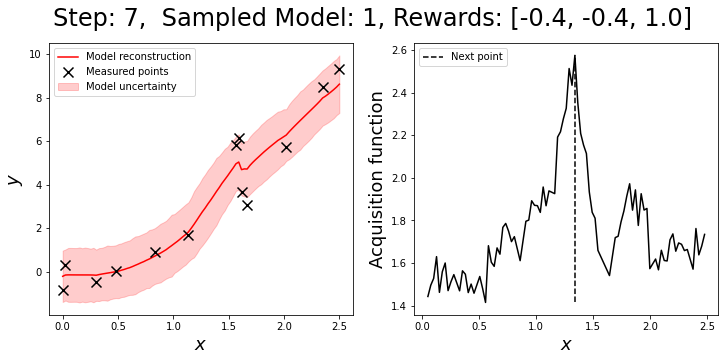

Exploration step 11/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:29<00:00, 44.79it/s, 1023 steps of size 5.31e-04. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.86      0.16      3.86      3.60      4.11     50.76      1.02
     beta2      2.46      0.08      2.46      2.34      2.60     28.27      1.07
  k_length      0.55      0.28      0.57      0.13      0.98     27.90      1.00
   k_scale      0.35      0.34      0.25      0.03      0.70     40.06      1.01
     noise      0.27      0.12      0.25      0.09      0.42     47.75      1.01
         t      1.60      0.01      1.60      1.59      1.62     65.62      1.00



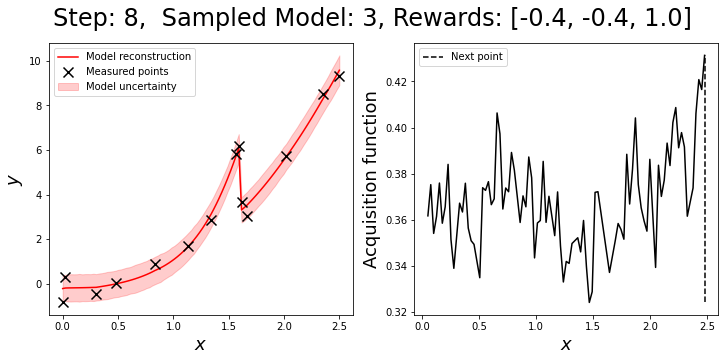

Exploration step 12/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:27<00:00, 45.66it/s, 1023 steps of size 8.04e-05. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.40      0.49      2.26      1.90      3.56      8.60      1.10
         c      3.15      0.40      3.19      2.52      3.70      2.73      2.36
  k_length      0.57      0.15      0.58      0.35      0.82     10.02      1.02
   k_scale      1.66      0.87      1.51      0.69      2.70      4.47      1.46
     noise      0.84      0.22      0.78      0.54      1.18      3.02      1.95
         t      1.38      0.17      1.42      1.13      1.65     10.85      1.00



sample: 100%|██████████| 4000/4000 [01:22<00:00, 48.38it/s, 1023 steps of size 3.02e-05. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.31      0.26      2.32      1.81      2.67      4.85      1.37
         c      3.71      0.16      3.68      3.47      3.95      3.66      1.49
  k_length      0.44      0.08      0.44      0.32      0.56      9.74      1.08
   k_scale      0.51      0.11      0.52      0.33      0.69      2.72      2.30
     noise      1.22      0.15      1.18      1.05      1.53      4.00      1.49
         t      1.47      0.06      1.48      1.40      1.57      8.27      1.16



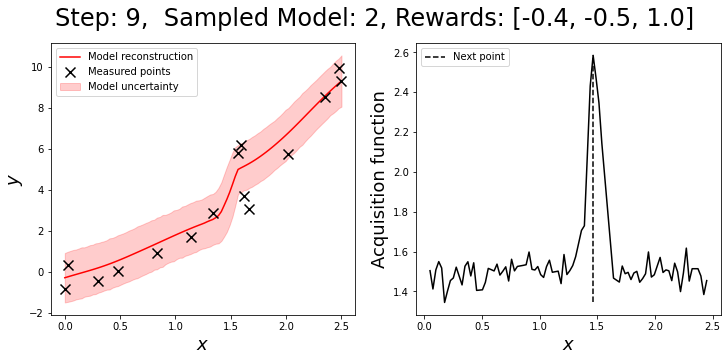

Exploration step 13/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:32<00:00, 43.10it/s, 1023 steps of size 3.51e-03. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.87      0.17      3.88      3.58      4.12    619.54      1.00
     beta2      2.48      0.07      2.49      2.35      2.58    721.12      1.00
  k_length      0.63      0.25      0.66      0.27      1.00    795.21      1.00
   k_scale      0.38      0.35      0.28      0.04      0.78    823.89      1.00
     noise      0.25      0.13      0.22      0.09      0.41    535.62      1.00
         t      1.60      0.01      1.60      1.59      1.62    543.06      1.00



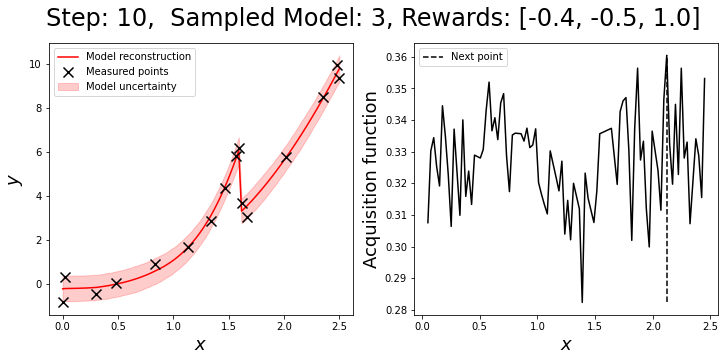

Exploration step 14/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:34<00:00, 42.22it/s, 1023 steps of size 3.15e-05. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.57      0.15      3.53      3.36      3.86     10.29      1.00
         c      2.65      0.11      2.69      2.47      2.80      3.33      1.84
  k_length      0.41      0.04      0.42      0.33      0.47      6.83      1.00
   k_scale      1.59      0.16      1.55      1.35      1.79      5.25      1.20
     noise      0.51      0.04      0.51      0.45      0.57      3.94      1.27
         t      1.61      0.02      1.61      1.59      1.64     10.73      1.07



sample: 100%|██████████| 4000/4000 [01:33<00:00, 42.94it/s, 1023 steps of size 1.33e-03. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.28      0.78      3.22      2.10      4.51      5.05      1.55
         c      3.35      0.58      3.39      2.37      4.33      5.04      1.64
  k_length      0.63      0.26      0.69      0.25      1.00     15.36      1.02
   k_scale      1.49      1.15      1.09      0.20      3.27      6.65      1.41
     noise      0.92      0.45      0.89      0.20      1.58     11.97      1.29
         t      1.52      0.10      1.54      1.36      1.63      2.72      2.36



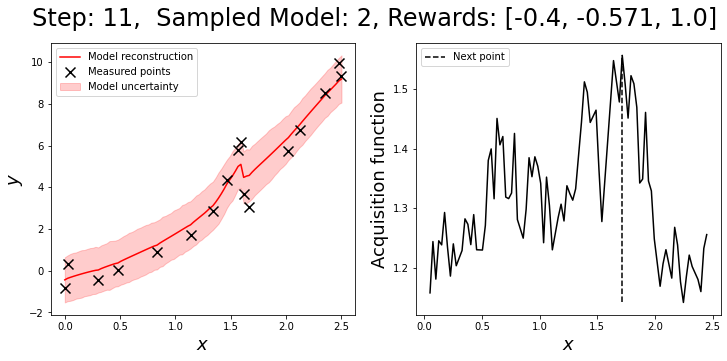

Exploration step 15/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:56<00:00, 34.43it/s, 1023 steps of size 3.47e-03. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.83      0.17      3.84      3.56      4.10    567.27      1.00
     beta2      2.48      0.07      2.49      2.37      2.60    529.09      1.00
  k_length      0.64      0.25      0.68      0.28      1.00    415.99      1.00
   k_scale      0.36      0.36      0.25      0.03      0.74    665.74      1.00
     noise      0.23      0.11      0.21      0.09      0.37    475.71      1.00
         t      1.60      0.01      1.60      1.59      1.61    351.57      1.00



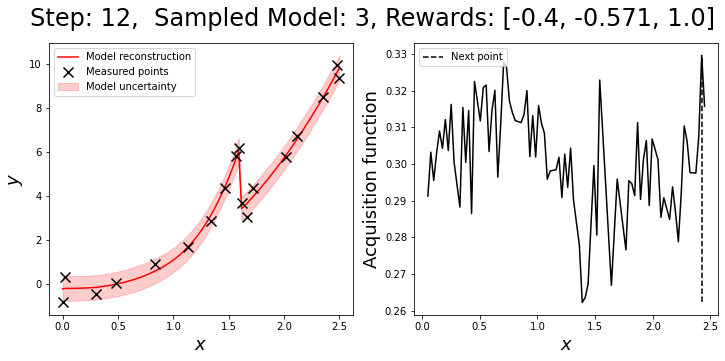

In [ ]:
exploration_steps = 15
eps = 0.4
warmup_steps = 3
models = [piecewise1, piecewise2, piecewise3]
model_priors = [piecewise1_priors, piecewise2_priors, piecewise3_priors]
save_reconstruction = True  # available only for exploration phase


onp.random.seed(55)  # rng seed for epsilon-greedy sampling
record = onp.zeros((len(models), 2))
model_choices = []
obj_history = []
# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []
    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):
        # for each model, run BI and store uncertainty values
        obj, _ = step(model, model_priors[i], X_train, y_train, X_test)
        record[i, 0] += 1
        obj_all.append(obj)
        obj_median_all.append(jnp.nanmedian(obj).item())  # (one can use integral uncertainty instead of median)
    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = onp.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1
    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])
    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Evaluate the function in the suggested point
    measured_point = y_test[next_point_idx]
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))
    # Choose model according to epsilon-greedy policy
    if onp.random.random() > eps: 
        idx = get_best_model(record)
    else:
        idx = onp.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))
    # Derive acqusition function with the selected model
    obj, m_post = step(models[idx], model_priors[idx], X_train, y_train, X_test, num_restarts=2)
    # Get reward
    r = get_reward(obj_history, obj)
    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())
    # Evaluate function in the suggested point
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    measured_point = y_test[next_point_idx]
    if save_reconstruction:    
        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X)
        plot_results(X_train, y_train, X_test, y_pred, y_sampled.squeeze(), obj, idx+1, record[:, 1],  e=e)
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))

Plot integral/median uncerainty as a function of exploration steps:

(note that for the warm-up steps, we plot only model that produced lowest uncertainty)

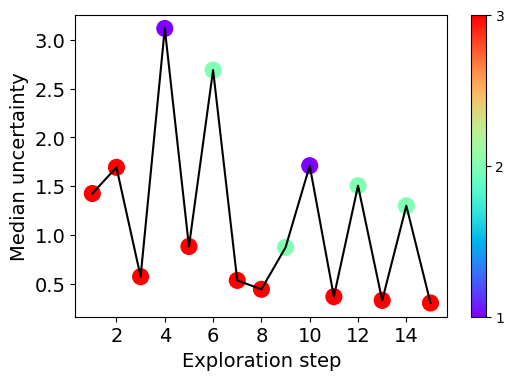

In [ ]:
plt.figure(dpi=100)
plt.plot(onp.arange(1, exploration_steps+1), obj_history, c='k')
plt.scatter(onp.arange(1, exploration_steps+1), obj_history,
            c=[m+1 for m in model_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Median uncertainty", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3])

View average reward associated with each model:

(note that it counts the warmup steps where all the models were evaluated)

In [ ]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))

model 1:  counts 5  reward (avg) -0.4
model 2:  counts 7  reward (avg) -0.571
model 3:  counts 9  reward (avg) 1.0


Compute (and plot) each model's prediction over the entire grid using the final set of the discovered point:


sample: 100%|██████████| 4000/4000 [02:01<00:00, 32.81it/s, 1023 steps of size 2.74e-03. acc. prob=0.79]



 Model 1, Reward (avg) -0.4


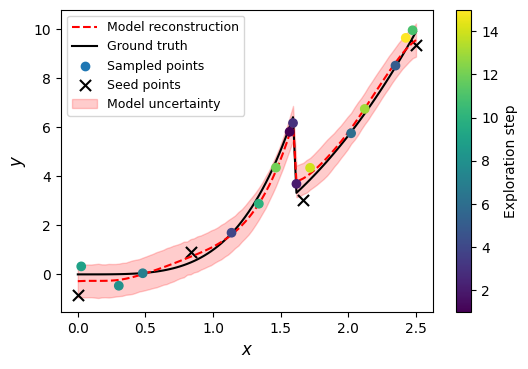

sample: 100%|██████████| 4000/4000 [01:51<00:00, 36.00it/s, 1023 steps of size 8.61e-05. acc. prob=0.87]



 Model 2, Reward (avg) -0.571


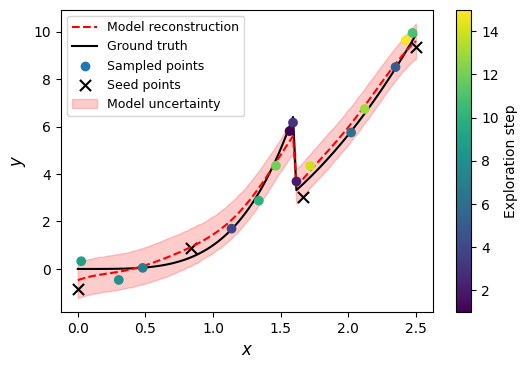

sample: 100%|██████████| 4000/4000 [02:09<00:00, 30.94it/s, 1023 steps of size 2.66e-03. acc. prob=0.77]



 Model 3, Reward (avg) 1.0


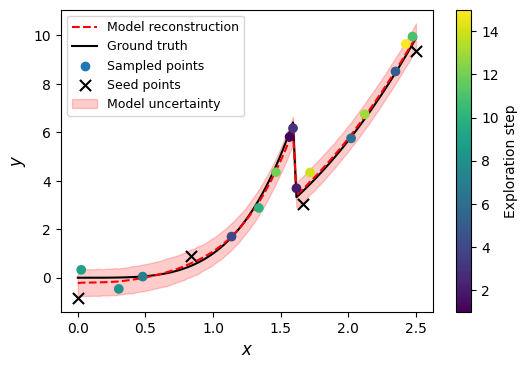

In [ ]:
for i, model in enumerate(models):
    # same as in the main loop, we use restarts to help avoiding bad initialization
    _, gp_model = step(model, model_priors[i], X_train, y_train, num_restarts=2, print_summary=0)
    y_pred, y_sampled = gp_model.predict(gpax.utils.get_keys()[1], X)
    print("\n Model {}, Reward (avg) {}".format(i+1, onp.round(record[i, 1], 3)))
    plot_final_result(X_train, y_train, X, y_pred, y_sampled.squeeze(), seed_points=num_seed_points)

We see that the model which received the highest reward (i.e., is
favored by our algorithm) clearly provided the best fit. Hence, we were able both to learn a correct data distribution with a small number of sparse measurements while also identifying a correct model that describes the system’s behavior.